In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import Dict, List
import torchvision
import torchvision.transforms as transforms

In [3]:
class Autoencoder(nn.Module):
    def __init__(self, input_size: int = 784, hidden_size: int = 128, latent_size: int = 32, dropout: float = 0.2):
        """
        Initialize the Autoencoder with encoder and decoder components.

        Parameters:
            input_size (int): Size of the input (e.g., 784 for MNIST 28x28 flattened)
            hidden_size (int): Size of the intermediate hidden layer
            latent_size (int): Size of the compressed latent representation
            dropout (float): Dropout probability for regularization
        """
        super(Autoencoder, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.latent_size = latent_size

        # Encoder: FC -> ReLU -> latent
        self.encoder = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, latent_size)
        )

        # Decoder: FC -> Sigmoid
        self.decoder = nn.Sequential(
            nn.Linear(latent_size, hidden_size),
            nn.ReLU(),  # Optional ReLU for better gradient flow
            nn.Linear(hidden_size, input_size),
            nn.Sigmoid()  # Output range [0, 1] to match MNIST input
        )

        self.dropout = nn.Dropout(dropout)
        self._initialize_weights()

    def _initialize_weights(self):
        """Initialize network weights using Xavier initialization."""
        for module in self.modules():
            if isinstance(module, nn.Linear):
                nn.init.xavier_normal_(module.weight)
                nn.init.zeros_(module.bias)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Forward pass through the autoencoder.

        Parameters:
            x (torch.Tensor): Input tensor of shape (batch_size, input_size)

        Returns:
            torch.Tensor: Reconstructed output of shape (batch_size, input_size)
        """
        latent = self.encoder(self.dropout(x))  # Compress to latent space
        reconstructed = self.decoder(latent)    # Reconstruct from latent
        return reconstructed

    def train_model(self,
                    train_loader: DataLoader,
                    test_loader: DataLoader,
                    num_epochs: int,
                    learning_rate: float,
                    device: torch.device = torch.device("cuda" if torch.cuda.is_available() else "cpu"),
                    patience: int = 2) -> Dict[str, List[float]]:
        """
        Train the autoencoder with early stopping based on test loss.

        Parameters:
            train_loader (DataLoader): DataLoader for training data
            test_loader (DataLoader): DataLoader for test data
            num_epochs (int): Number of training epochs
            learning_rate (float): Learning rate for the optimizer
            device (torch.device): Device to run training on (default: CUDA if available, else CPU)
            patience (int): Number of epochs to wait for improvement before early stopping

        Returns:
            Dict[str, List[float]]: Training history with loss metrics
        """
        self.to(device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        history = {"train_loss": [], "test_loss": []}
        best_test_loss = float("inf")
        patience_counter = 0

        for epoch in range(num_epochs):
            self.train()
            total_train_loss = 0.0

            for images, _ in train_loader:  # Ignore labels
                images = images.view(-1, self.input_size).to(device)

                optimizer.zero_grad()
                outputs = self(images)
                loss = criterion(outputs, images)
                loss.backward()
                optimizer.step()

                total_train_loss += loss.item()

            # Compute epoch metrics
            train_loss = total_train_loss / len(train_loader)
            test_loss = self.evaluate(test_loader, device)

            history["train_loss"].append(train_loss)
            history["test_loss"].append(test_loss)

            print(f"Epoch [{epoch+1}/{num_epochs}]")
            print(f"Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

            # Early stopping
            if test_loss < best_test_loss:
                best_test_loss = test_loss
                patience_counter = 0
                torch.save(self.state_dict(), "best_autoencoder.pt")
            else:
                patience_counter += 1
                if patience_counter >= patience:
                    print(f"Early stopping at epoch {epoch+1}")
                    break

        # Load best model
        self.load_state_dict(torch.load("best_autoencoder.pt"))
        return history

    def evaluate(self, test_loader: DataLoader, device: torch.device) -> float:
        """
        Evaluate reconstruction loss on test data.

        Parameters:
            test_loader (DataLoader): DataLoader for test data
            device (torch.device): Device to run evaluation on

        Returns:
            float: Average MSE loss on the test set
        """
        self.eval()
        total_loss = 0.0

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.view(-1, self.input_size).to(device)
                outputs = self(images)
                loss = nn.MSELoss()(outputs, images)
                total_loss += loss.item()

        return total_loss / len(test_loader)

    def reconstruct(self, test_loader: DataLoader, device: torch.device) -> List[torch.Tensor]:
        """
        Generate reconstructions from test data.

        Parameters:
            test_loader (DataLoader): DataLoader for test data
            device (torch.device): Device to run reconstruction on

        Returns:
            List[torch.Tensor]: List of reconstructed images
        """
        self.eval()
        reconstructions = []

        with torch.no_grad():
            for images, _ in test_loader:
                images = images.view(-1, self.input_size).to(device)
                outputs = self(images)
                reconstructions.append(outputs.cpu())

        return reconstructions

def plot_training_history(history: Dict[str, List[float]]):
    """
    Plot training and test loss over epochs.

    Parameters:
        history (Dict[str, List[float]]): Training history with loss metrics
    """
    plt.figure(figsize=(8, 6))
    plt.plot(history["train_loss"], label="Train Loss")
    plt.plot(history["test_loss"], label="Test Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.title("Autoencoder Training History")
    plt.legend()
    plt.show()

In [4]:
# Hyperparameters
input_size = 784  # 28x28
hidden_size = 128
latent_size = 32
batch_size = 64
num_epochs = 10
learning_rate = 0.001

In [5]:
# Load MNIST
transform = transforms.ToTensor()
train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
test_dataset = torchvision.datasets.MNIST(root="./data", train=False, transform=transform, download=True)
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

Epoch [1/10]
Train Loss: 0.0312, Test Loss: 0.0149
Epoch [2/10]
Train Loss: 0.0157, Test Loss: 0.0115
Epoch [3/10]
Train Loss: 0.0136, Test Loss: 0.0101
Epoch [4/10]
Train Loss: 0.0125, Test Loss: 0.0095
Epoch [5/10]
Train Loss: 0.0117, Test Loss: 0.0089
Epoch [6/10]
Train Loss: 0.0111, Test Loss: 0.0085
Epoch [7/10]
Train Loss: 0.0107, Test Loss: 0.0081
Epoch [8/10]
Train Loss: 0.0103, Test Loss: 0.0078
Epoch [9/10]
Train Loss: 0.0100, Test Loss: 0.0076
Epoch [10/10]
Train Loss: 0.0098, Test Loss: 0.0075


<ipython-input-3-7609d0a6d215>:122: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.load_state_dict(torch.load("best_autoencoder.pt"))


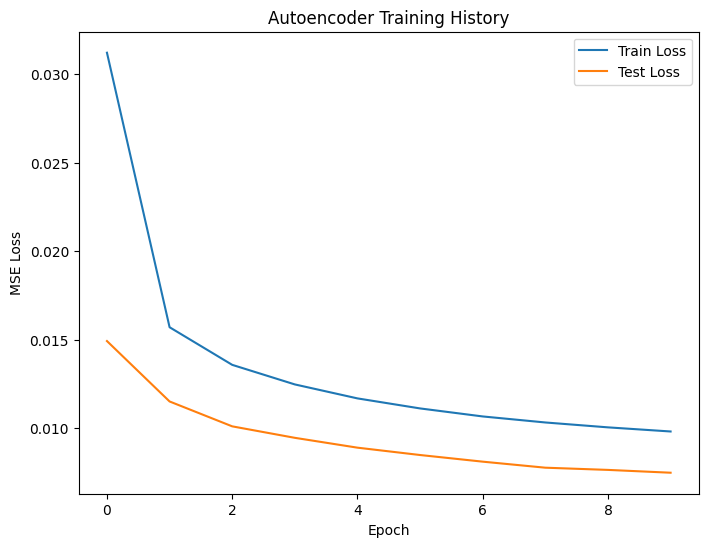

In [6]:
# Initialize and train model
model = Autoencoder(input_size, hidden_size, latent_size)
history = model.train_model(train_loader, test_loader, num_epochs, learning_rate)
plot_training_history(history)

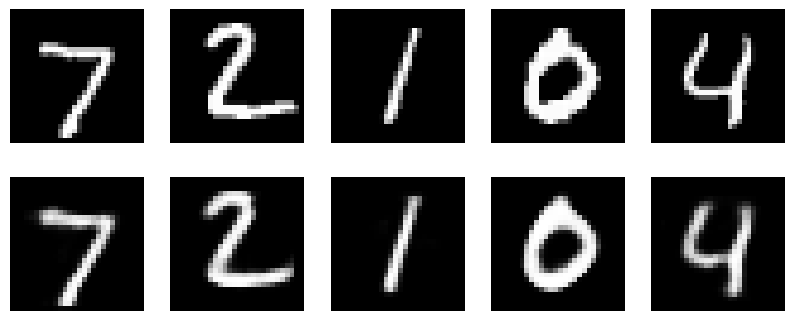

In [9]:
# Visualize reconstructions (optional)
reconstructions = model.reconstruct(test_loader, torch.device("cuda"))
original = next(iter(test_loader))[0]
plt.figure(figsize=(10, 4))
for i in range(5):
    plt.subplot(2, 5, i+1)
    plt.imshow(original[i].reshape(28, 28), cmap="gray")
    plt.axis("off")
    plt.subplot(2, 5, i+6)
    plt.imshow(reconstructions[0][i].reshape(28, 28), cmap="gray")
    plt.axis("off")
plt.show()

In [13]:
latent_vectors = []
labels = []
with torch.no_grad():
    for images, lbls in test_loader:
        images = images.view(-1, 784).to(torch.device("cuda"))
        latent = model.encoder(images)
        latent_vectors.append(latent.cpu())
        labels.append(lbls)
latent_vectors = torch.cat(latent_vectors)
labels = torch.cat(labels)

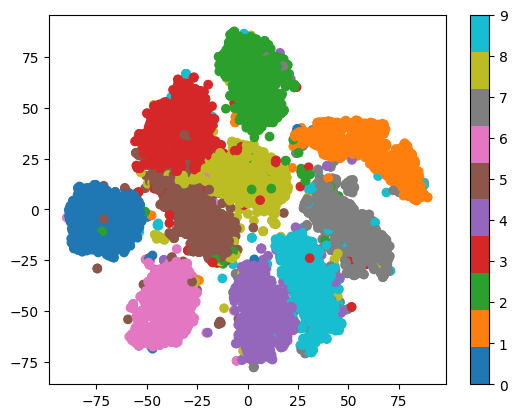

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2)
latent_2d = tsne.fit_transform(latent_vectors.numpy())
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=labels.numpy(), cmap="tab10")
plt.colorbar()
plt.show()